In [153]:
from imports import *
from utils import process_file

In [154]:
warnings.filterwarnings("ignore")

### **Ajuste de modelos** 

* **A partir de las transformaciones propuestas ajustar distintos modelos (S)ARIMA. Extraer orden, parámetros, coeficientes numéricos y análisis de la bondad del modelo.**
* Ajustar y predecir usando redes neuronales LSTM.
* Comparar con predicciones usando SARIMA y extraer conclusiones.
* Reailzar el análisis espectral de la serie original. Hallar las frecuencias principales y comparar con las componentes cíclica y estacional usando la descomposición.

#### Cargamos dataset ya preprocesado

In [155]:
bicis_data = process_file()

In [156]:
type(bicis_data)

pandas.core.series.Series

#### Fiteamos un MA(7)
El valor 7 lo elegimos a partir de observar los graficos de acf y pacf en notebook de EDA

In [157]:
order = 7
ma_model = ARIMA(bicis_data, order=(0, 0, order)).fit()
#ma_model.summary()

#### Fiteamos un AR(7)
El valor 7 lo elegimos a partir de observar los graficos de acf y pacf

In [158]:
lag_order = 7
ar_model = AutoReg(bicis_data, lags=lag_order).fit()
#ar_model.summary()

In [159]:
def plot_error(model, model_name):
    err_raw = model.predict() - bicis_data
    plt.violinplot([err_raw.dropna(), bicis_data.dropna()])
    plt.title(model_name)
    plt.grid()

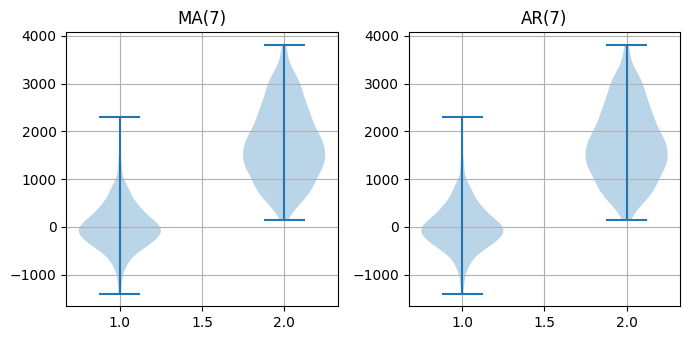

In [160]:
plt.figure(figsize=(7,3.5))
plt.subplot(1, 2, 1)
plot_error(ar_model, "MA(7)")
plt.subplot(1, 2, 2)
plot_error(ar_model, "AR(7)")
plt.tight_layout()
plt.show()

In [161]:
def plot_relative_error(model, model_name):
    #Para calcular el error relativo, eliminamos los ceros que corresponden a 13 datapoints
    mask = bicis_data > 0
    err_raw = model.predict() - bicis_data
    percentiles = np.percentile((err_raw[mask] / bicis_data[mask]).dropna(), [25,50,75])
    print("percentiles:", f'{model_name}', percentiles)
    plt.violinplot((err_raw[mask] / bicis_data[mask]).dropna(), points=300)
    plt.hlines(percentiles, 0.7, 1.3, color='k', linestyle='--')
    plt.ylim(-2,3)
    plt.title(model_name)
    plt.grid()
    

percentiles: Error relativo: AR(7) [-0.13584936 -0.0228191   0.21956661]
percentiles: Error relativo: MA(7) [-0.14561456 -0.00641774  0.31278894]


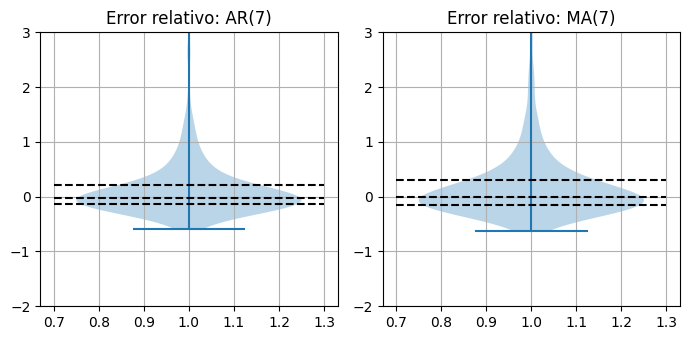

In [162]:
plt.figure(figsize=(7,3.5))
plt.subplot(1, 2, 1)
plot_relative_error(ar_model, "Error relativo: AR(7)")
plt.subplot(1, 2, 2)
plot_relative_error(ma_model, "Error relativo: MA(7)")
plt.tight_layout()
plt.show()

##### **Observacion**

* La mediana del error del **modelo autoregresivo** esta en -0.022, lo que significa que el **50%** de las veces predice alrededor de 2.2% menos que la data real.  El **25%** de las veces predice por defecto por lo menos un 13% menos que la data real.
En el extremo superior, en el percentil **75** ,predice por exceso al menos un 21% mas que la data real.

* La mediana del error del **modelo moving average** esta en -0.006, lo que significa que el **50%** de las veces predice alrededor de 0.6% menos que la data real.  El **25%** de las veces predice por defecto por lo menos un 14% menos que la data real.
En el extremo superior, en el percentil **75** ,predice por exceso al menos un 31% mas que la data real.
 


#### Fiteamos un ARIMA(7,1,7)

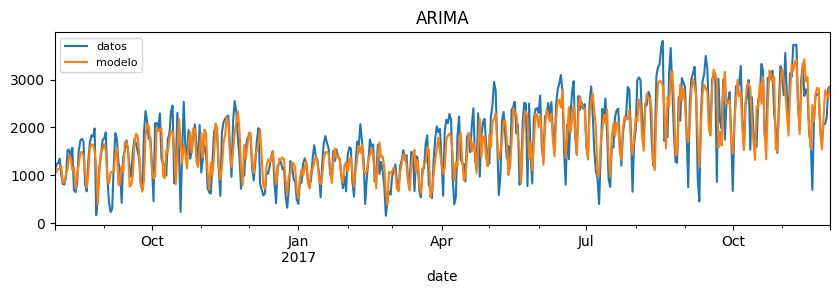

time to fit:  1.32 seg


In [163]:
def plotARMA(series,ax):
    mod = sm.tsa.ARIMA(series, order=(7,1,7), missing='raise').fit()
    series.plot(ax=ax,label="datos")
    mod.predict()[1:].plot(ax=ax,label="modelo")
    return mod

fig,ax = plt.subplots(figsize=(10,2.5))    
t0 = time()
arima = plotARMA(bicis_data,ax)
arima_time = time() - t0

plt.legend(fontsize=8)
plt.title("ARIMA")
plt.show()

arima_time_rounded = round(arima_time, 2)
print("time to fit: ", arima_time_rounded, "seg")

percentiles: Error relativo ARIMA [-0.15565632 -0.04481075  0.12405158]


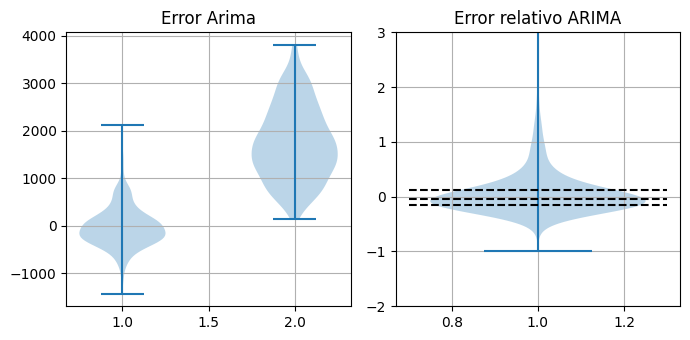

In [164]:
plt.figure(figsize=(7,3.5))
plt.subplot(1, 2, 1)
plot_error(arima, "Error Arima")
plt.subplot(1, 2, 2)
plot_relative_error(arima, "Error relativo ARIMA")
plt.tight_layout()
plt.show()

### ARIMA FORECAST

In [165]:
from arima_models import *

#### 1. Split into train and test sets

In [166]:
X = bicis_data
size = int(len(X) * 0.85)
train, test = X[0:size], X[size:len(X)]

#### 2. **Simple forecast model**: 
Fit on train, forecast on test

Test RMSE: 604.401


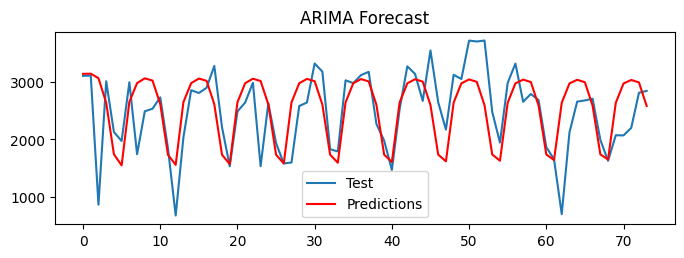

time to fit:  1.25 seg


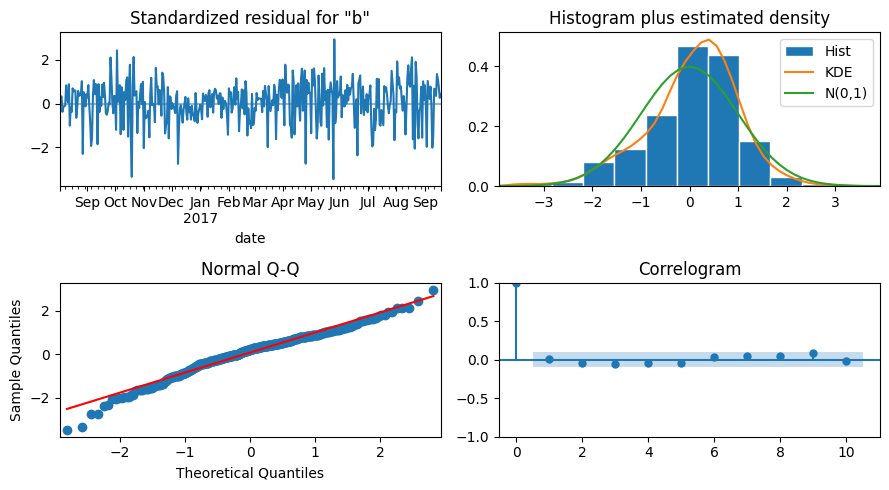

In [167]:
t0 = time()

order = (7, 1, 7)
arima_forecast = arima_forecast(train, test, order)
arima_forecast_time = time() - t0

arima_forecast_time = round(arima_forecast_time, 2)
print("time to fit: ", arima_forecast_time, "seg")

# Plot diagnostics
arima_forecast.plot_diagnostics(figsize=(9, 5))
plt.tight_layout()
plt.show()

#print(arima_forecast.summary())


**Summary Arima forecast**


#### 3. **Rolling forecast model**: 
Actualizamos de manera iterativa el train set con los valores observados en el test set y volvemos a fitear el modelo para predecir para los siguientes time steps.

Test RMSE: 606.121


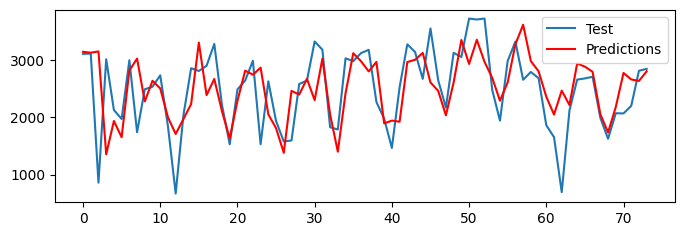

time to fit:  99.71 seg


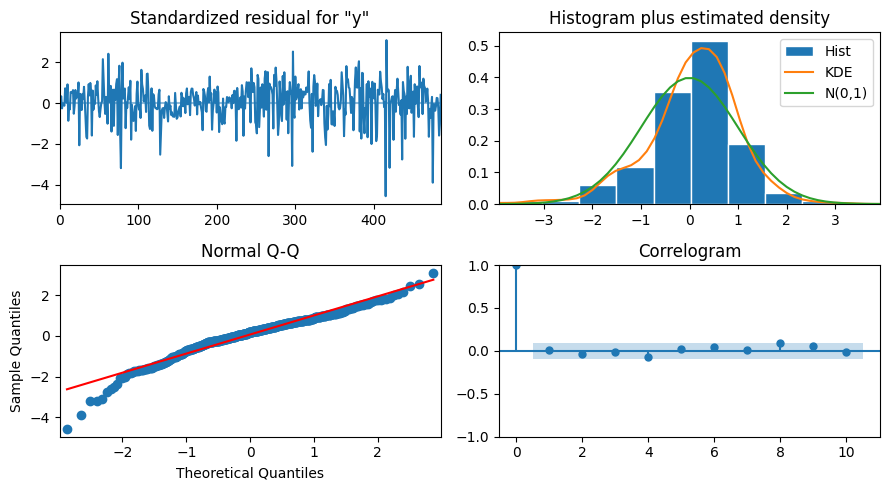

In [168]:
t0 = time()

order = (7, 1, 7)
arima_rolling_forecast = arima_rolling_forecast(train, test, order)
arima_rolling_forecast_time = time() - t0

arima_rolling_forecast_time = round(arima_rolling_forecast_time, 2)
print("time to fit: ", arima_rolling_forecast_time, "seg")

# Plot diagnostics
arima_rolling_forecast.plot_diagnostics(figsize=(9, 5))
plt.tight_layout()
plt.show()

#print(arima_rolling_forecast.summary())


**Summary Arima Rolling forecast**

###  Fiteamos un SARIMA order=(7,1,7), seasonal_order=(4,1,4,28)
seasonal order 4 = 4 meses, s = 28 porque cada ciclo tiene 28 dias 

##### SARIMA order parameters
* p = ??  # Autoregressive order
* d = ??  # Differencing order
* q = ??  # Moving average order
* P = ??  # Seasonal autoregressive order
* D = ??  # Seasonal differencing order
* Q = ??  # Seasonal moving average order
* s = ??  # Seasonal period

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.10895D+00    |proj g|=  1.81613D-01


 This problem is unconstrained.



At iterate    5    f=  6.98881D+00    |proj g|=  3.98810D-03

At iterate   10    f=  6.98834D+00    |proj g|=  2.00086D-03

At iterate   15    f=  6.98791D+00    |proj g|=  2.05419D-03

At iterate   20    f=  6.98714D+00    |proj g|=  1.36315D-02

At iterate   25    f=  6.98590D+00    |proj g|=  5.34359D-03

At iterate   30    f=  6.98550D+00    |proj g|=  4.17860D-03

At iterate   35    f=  6.98534D+00    |proj g|=  3.21777D-03

At iterate   40    f=  6.98483D+00    |proj g|=  5.77652D-03

At iterate   45    f=  6.98424D+00    |proj g|=  2.07831D-02

At iterate   50    f=  6.98395D+00    |proj g|=  4.84675D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

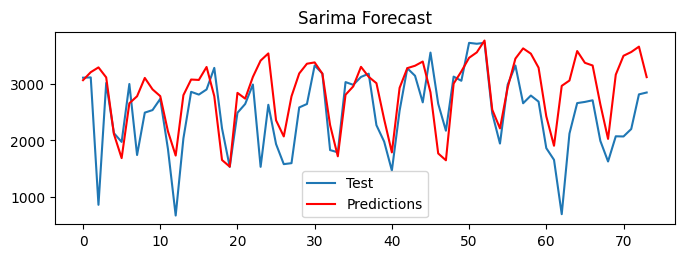

time to fit:  264.72 seg


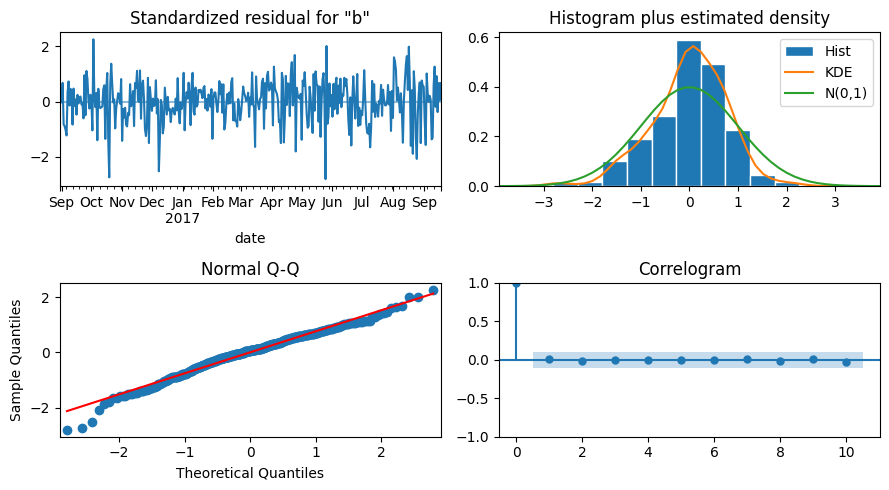

In [169]:
t0 = time()

order = (7, 1, 7)
seasonal_order=(4,1,4,28)

sarima_forecast = sarima_forecast(train, test, order, seasonal_order)
sarima_forecast_time = time() - t0

sarima_forecast_time = round(sarima_forecast_time, 2)
print("time to fit: ", sarima_forecast_time, "seg")

# Plot diagnostics
sarima_forecast.plot_diagnostics(figsize=(9, 5))
plt.tight_layout()
plt.show()

#print(sarima_forecast.summary())


**Summary Sarima forecast**


#### Observaciones

1. Dividimos la serie en train (0.85) y test (0.15). Fiteamos en train y predecimos en test.
2. Primero probamos con un modelo arima normal con parametros AR=7, I=1 y MA=7. El root mean squared error (RMSE) en Test es **604.401** y demora **1.71 seg** en entrenar.
3. Probamos un rolling forecast model, esto es actualizamos de manera iterativa el train set con los valores observados en el test set y volvemos a fitear el modelo para predecir para los siguientes time steps. El RMSE en Test es **606.121** y demora **97.97 seg**
4. Fiteamos un Sarima con AR=7, I=1 y MA=7 y seasonal orden SAR=4, S=1, SMA=4, s=28, porque en el grafico de la serie original vemos 4 meses de ciclos y cada uno de ellos tiene 28 dias. El RMSE en test es **714.735** y demora  **266.64 seg**. 

**Respecto de los valores de Summary:**

**Log Likelihood:** El valor de la log-likelihood para el modelo SARIMA es más alto que el de los modelos ARIMA forecast y ARIMA rolling forecast, lo que sugiere un mejor ajuste del modelo SARIMA a los datos.

**AIC y BIC:** Tanto el AIC como el BIC para el modelo SARIMA son más bajos que los valores correspondientes en los modelos ARIMA. Esto indica que el modelo SARIMA es preferible en términos de calidad de ajuste y complejidad del modelo.

**Ljung-Box (Q):** El valor de Q para el modelo SARIMA es similar al de los modelos ARIMA, lo que sugiere que los residuos del modelo SARIMA también podrían tener autocorrelación residual insignificante.

**Jarque-Bera (JB):** El estadistico y p valor de Jarque-Bera para los modelos ARIMA y SARIMA son similares y nos indican que hay fuerte evidencia para rechazar la hipotesis nula de la distribucion normal de los residuos. En otras palabras, los valores residuales de los modelos no estan normalmente distribuidos.

**Heteroskedasticity (H):** El valor de heteroscedasticidad para los modelos ARIMA y SARIMA son similares lo que indica una variabilidad similar en los residuos a lo largo del tiempo. Se observa algun nivel de heteroscedasticidad en los 3 modelos.

#### Conclusiones
El modelo SARIMA FORECAST con parametros con AR=7, I=1 y MA=7 y seasonal orden SAR=4, S=1, SMA=4, s=28 tiene el error mas bajo pero demora aprox **266.64 seg**.

**Residual**: hay un poco de heterocesdatiscidad, de acuerdo con los graficos observamos que el residual no esta normalmente distribuido. Procedemos a realizar transformacion de box cox sobre la serie y volvemos a fitear un arima con parametros AR=7, I=1 y MA=7

#### Transformacion de Box-Cox


In [170]:
from scipy.stats import boxcox

transformed_data, lambda_value = boxcox(bicis_data)
print("Optimal lambda for Box-Cox transformation:", lambda_value)

Optimal lambda for Box-Cox transformation: 0.6220124039749927


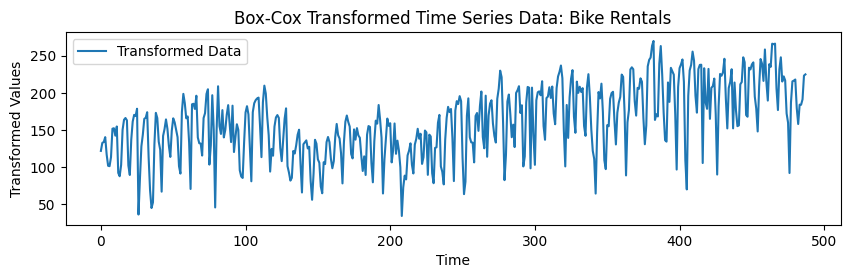

In [171]:
plt.figure(figsize=(10, 2.5))
plt.plot(transformed_data, label='Transformed Data')
plt.title('Box-Cox Transformed Time Series Data: Bike Rentals')
plt.xlabel('Time')
plt.ylabel('Transformed Values')
plt.legend()
plt.show()

In [172]:
# convierto array en pd.Series
transformed_series = pd.Series(transformed_data, index=bicis_data.index)

# Divido en train y test
X = transformed_series
size = int(len(X) * 0.85)
train_trf, test_trf = X[0:size], X[size:len(X)]

#### Fit ARIMA FORECAST with transformed timeseries

In [175]:
from arima_models import *

Test RMSE: 35.362


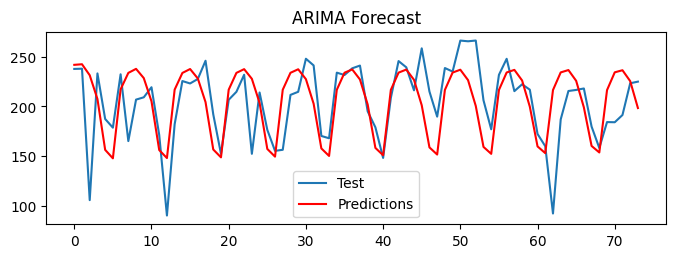

time to fit:  1.38 seg


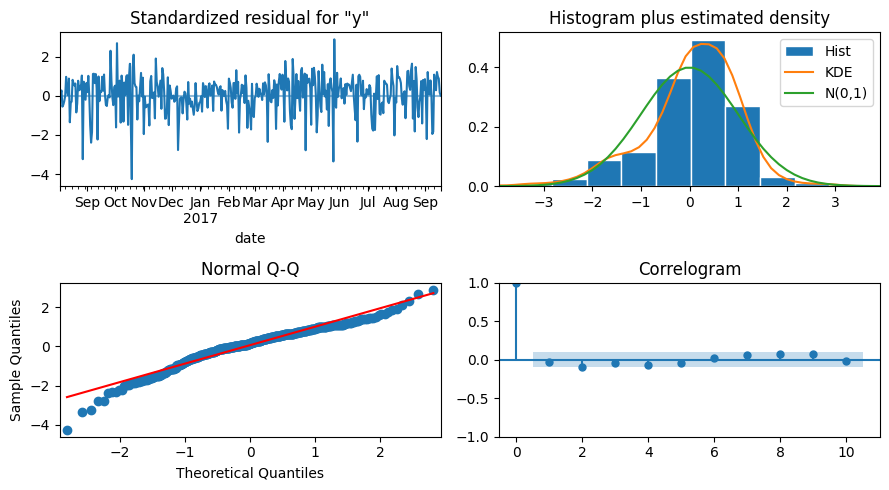

In [179]:
t0 = time()

order = (7, 1, 7)

arima_transformed = arima_forecast(train_trf, test_trf, order)
arima_transformed_time = time() - t0

arima_transformed_time = round(arima_transformed_time, 2)
print("time to fit: ", arima_transformed_time, "seg")

# Plot diagnostics
arima_transformed.plot_diagnostics(figsize=(9, 5))
plt.tight_layout()
plt.show()

#print(arima_transformed.summary())

**Summary Arima Transformed**

#### Fit SARIMA FORECAST with transformed timeseries

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.57959D+00    |proj g|=  2.15677D-01

At iterate    5    f=  4.45071D+00    |proj g|=  1.11115D-02

At iterate   10    f=  4.44148D+00    |proj g|=  1.85537D-02

At iterate   15    f=  4.40382D+00    |proj g|=  4.16366D-02

At iterate   20    f=  4.39568D+00    |proj g|=  9.48411D-02

At iterate   25    f=  4.39404D+00    |proj g|=  1.21731D-02

At iterate   30    f=  4.39326D+00    |proj g|=  1.02617D-02

At iterate   35    f=  4.39320D+00    |proj g|=  3.34205D-03

At iterate   40    f=  4.39310D+00    |proj g|=  2.77063D-03

At iterate   45    f=  4.39306D+00    |proj g|=  4.48617D-03

At iterate   50    f=  4.39298D+00    |proj g|=  9.68379D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

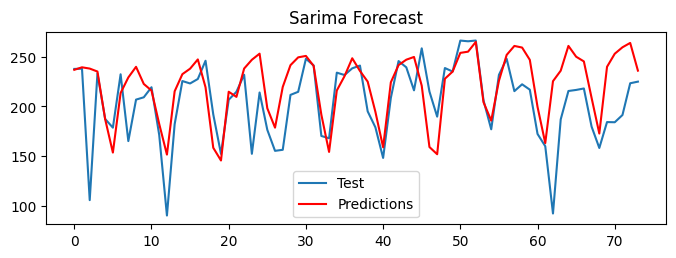

time to fit:  263.27 seg


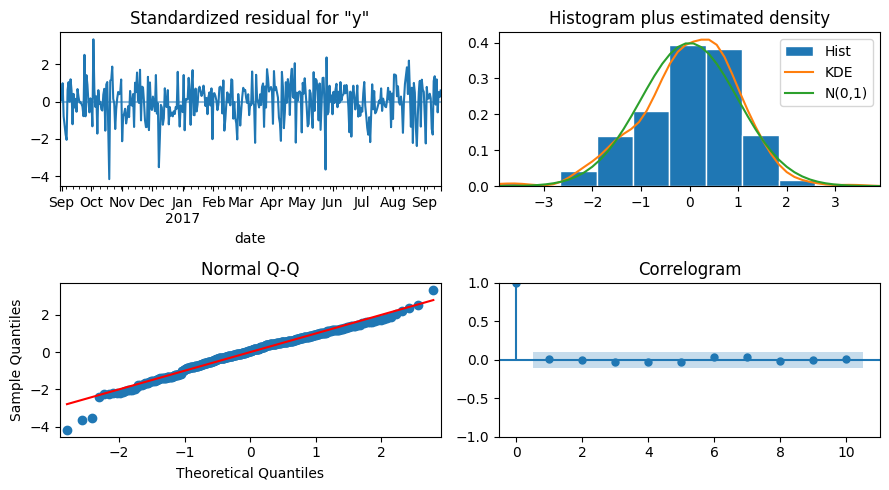

In [180]:
t0 = time()

order = (7, 1, 7)
seasonal_order=(4,1,4,28)

sarima_transformed = sarima_forecast(train_trf, test_trf, order)
sarima_transformed_time = time() - t0

sarima_transformed_time = round(sarima_transformed_time, 2)
print("time to fit: ", sarima_transformed_time, "seg")

# Plot diagnostics
sarima_transformed.plot_diagnostics(figsize=(9, 5))
plt.tight_layout()
plt.show()

#print(sarima_transformed.summary())

**Summary Sarima Transformed**

#### Observaciones

El modelo ARIMA FORECAST de la serie transformada con Box-Cox es mejor que el modelo ARIMA FORECAST de la serie no transformada en terminos de AIC y BIC, es decir balance de complejidad y performance. Observamos que el nivel de heterocedasticidad se reduce un poco, aunque los errores continuan sin seguir una distribucion normal. 

El RMSE en test es **35.362** y demora **1.66 seg** en entrenar.

Por otro lado, los valores de AIC y BIC son aun un poco mas bajos en el modelo SARIMA FORECAST de la serie transformada con Box-Cox. El RMSE en test es **37.460** y demora **263.27 seg** en entrenar.

**Conclusion:** El modelo ARIMA FORECAST de la serie transformada es el mejor compartivamente, teniendo en cuenta las metricas que nos ayudan a evaluar la robustez del modelo, el RMSE y el tiempo que demora en entrenar, que es un 99.37 % menos que el SARIMA FORECAST.

#### ACF y PACF de serie diferenciada

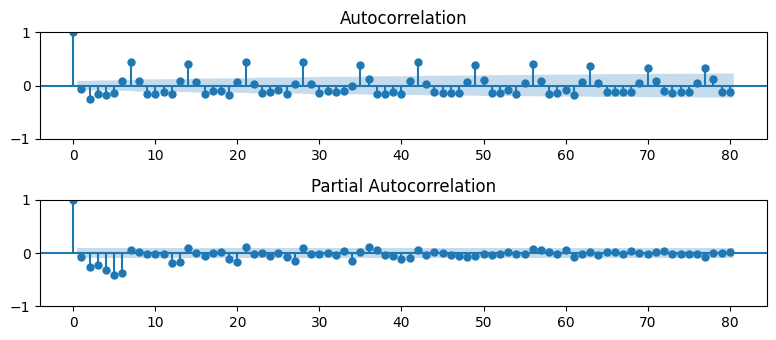

In [186]:
# Differencing to remove non-seasonal component
bicis_diff = bicis_data.diff().dropna()

# Plot the ACF and PACF of the differenced time series
fig, axes = plt.subplots(2, 1, figsize=(8, 3.5))
plot_acf(bicis_diff, lags=80, ax=axes[0])
plot_pacf(bicis_diff, lags=80, ax=axes[1])
plt.tight_layout()
plt.show()